In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.dates import DateFormatter
pd.options.mode.chained_assignment = None 
import xgboost as xgb

In [2]:
def plot_observed_vs_predicted_with_text(y_test, y_pred_test, site, mse, rmse, mae, r2, params, target_col,plot_directory):
        # Increase text size for better readability
    plt.rc('font', size=14)  # Default font size
    plt.rc('axes', titlesize=16)  # Title font size
    plt.rc('axes', labelsize=14)  # Axis labels font size
    plt.rc('xtick', labelsize=12)  # X-tick labels font size
    plt.rc('ytick', labelsize=12)  # Y-tick labels font size
    plt.rc('legend', fontsize=12)  # Legend font size
    # Plotting the observed vs predicted values for the test set
    plt.figure(figsize=(10, 6))
    plt.plot(pd.to_datetime(y_test.index), y_test, label='GPP', color='blue')
    plt.plot(pd.to_datetime(y_test.index), y_pred_test, label='Predicted GPP', color='red')
    plt.xlabel('date')
    plt.ylabel('Value')
    plt.title(f'GPP vs Predicted GPP using XGBoost at {site}')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate and align the date labels
    metrics_text = f'MSE: {mse:.4f}  RMSE: {rmse:.4f}  MAE: {mae:.4f}  R^2: {r2:.4f}'
    plt.figtext(0.5, 0.001, metrics_text, ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plot_directory,f"XGBOOST_{site}_{target_col}_{params}.png"))
    plt.show()
    # plt.savefig(f'./plots/{site}_observed_vs_predicted.png')
def plot_observed_vs_predicted_with_text1(y_test, y_pred_test, site, mse, rmse, mae, r2, params, target_col,plot_directory):
    plt.rc('font', size=14)  # Default font size
    plt.rc('axes', titlesize=16)  # Title font size
    plt.rc('axes', labelsize=14)  # Axis labels font size
    plt.rc('xtick', labelsize=12)  # X-tick labels font size
    plt.rc('ytick', labelsize=12)  # Y-tick labels font size
    plt.rc('legend', fontsize=12)  # Legend font size
    # Plotting the observed vs predicted values for the test set
    plt.figure(figsize=(15, 6))
    plt.plot(pd.to_datetime(y_test.index), y_test, label='Observed', color='blue')
    plt.plot(pd.to_datetime(y_test.index), y_pred_test, label='Predicted', color='red')
    plt.xlabel('date')
    plt.ylabel('Value')
    plt.title(f'GPP vs Predicted GPP using XGBoost at {site}')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()  # Rotate and align the date labels
    metrics_text = f'MSE: {mse:.4f}  RMSE: {rmse:.4f}  MAE: {mae:.4f}  R^2: {r2:.4f}'
    plt.figtext(0.5, 0.001, metrics_text, ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plot_directory,f"XGBOOST_{site}_{target_col}_{params}.png"))
    plt.show()
    # plt.savefig(f'./plots/{site}_observed_vs_predicted.png')
def initialize_model(eta, max_depth, min_child_weight, gamma, alpha):
    """
    Initialize and return a basic XGBoost model with given parameters.
    """
    params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'alpha': alpha,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }
    return params
def train_xgboost(df, target_col, params, num_round=10, xgb_model=None):
    """
    Train an XGBoost model or continue training from a given model.
    """
    X = df.reindex(sorted(df.columns), axis=1).drop(columns=[target_col])
    y = df[target_col]
    dtrain = xgb.DMatrix(X, label=y)
    model = xgb.train(params, dtrain, num_round, xgb_model=xgb_model)
    return model, X, y
def create_lags(df, L):
    """
    Create lag features for specified columns in the dataframe.
    """
    # for column in columns:
    #     for i in range(1, L+1):
    #         df[f'{column}_lag_{i}'] = df[column].shift(i)
    # return df.dropna()
    for column in df.columns[:-1]:
        if column not in ['day', 'month', 'latitude', 'longitude', 'elevation', 'canopy_height',
       'instrument_height', 'biom_croplands', 'biom_dbf', 'biom_enf',
       'biom_grasslands', 'winter', 'spring', 'summer', 'fall']:
            # for i in range(1, L + 1):
            # for i in range(0, L):
            for i in range(1, L):
                df[f'{column}_lag_{i}'] = df[column].shift(i)

    # Drop rows with NaNs resulting from lag creation
    df.dropna(inplace=True)
    return df
def XGBoost_train_test(df,target_col, eta, max_depth, min_child_weight, gamma, alpha, params_, plot_directory,site, L=3,test_size=0.2, num_round=10):
    """
    Initial training of the XGBoost model.
    """
    df = create_lags(df,  L)
    train_idx = int(len(df) * (1-test_size))
    df_train = df.iloc[:train_idx]
    df_test = df.iloc[train_idx:]
    X_test = df_test.reindex(sorted(df.columns), axis=1).drop(columns=[target_col])
    y_test = df_test[target_col]

    params = initialize_model(eta, max_depth, min_child_weight, gamma, alpha)
    model, X_train, y_train = train_xgboost(df_train, target_col, params, num_round)

    # Test the model
    dtest = xgb.DMatrix(X_test, label=y_test)
    preds = model.predict(dtest)
    mse = mean_squared_error(y_test, preds)
    test_r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mse)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('MAE:', mae)
    print("Test R^2 Score:", test_r2)
    plot_observed_vs_predicted_with_text(y_test, preds, site, mse, rmse, mae, test_r2, params_, target_col,plot_directory)
    return model, X_train, X_test, y_train, y_test, preds, mse,rmse,mae, test_r2, dtest
def XGBoost_train_test_cont(model,site, df,target_col, L=3,test_size=0.2, num_round=10):
    """
    Continue training the XGBoost model with new data.
    """
    df = create_lags(df, L)
    train_idx = int(len(df) * (1-test_size))
    df_train = df.iloc[:train_idx]
    df_test = df.iloc[train_idx:]
    X_test = df_test.reindex(sorted(df.columns), axis=1).drop(columns=[target_col])
    y_test = df_test[target_col]



    model, X_train, y_train = train_xgboost(df_train, target_col,{}, num_round, model)
    # Test the model
    dtest = xgb.DMatrix(X_test, label=y_test)
    preds = model.predict(dtest)
    mse = mean_squared_error(y_test, preds)
    test_r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mse)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('MAE:', mae)
    print("Test R^2 Score:", test_r2)
    # plot_observed_vs_predicted_with_text(y_test, preds, site, mse, rmse, mae, test_r2, params_, target_col,plot_directory)


    # Optionally, evaluate the model as needed
    return model, X_train, X_test, y_train, y_test, preds, mse,rmse,mae, test_r2, dtest
def f_importance(booster, X_train, site, params, plot_directory):
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams['legend.fontsize'] = 16

    # Get feature importances and normalize them
    importance = booster.get_score(importance_type='gain')
    # For features not used in splits, ensure they are also included in the dict with an importance of 0
    all_features = {col.replace('CLr', 'CIr'): 0 for col in X_train.columns}  # Rename during initialization
    all_features.update({k.replace('CLr', 'CIr'): v for k, v in importance.items()})  # Update with renamed features
    
    # Calculate total gain for normalization
    total_gain = sum(all_features.values())
    relative_importance = {k: v / total_gain for k, v in all_features.items()}

    # Create a DataFrame, sort by relative importance, and select the top 10
    df = pd.DataFrame(list(relative_importance.items()), columns=['Feature', 'Relative Importance'])
    df = df.sort_values('Relative Importance', ascending=False).head(10)

    # Plotting the relative importance of top 10 features
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df['Feature'], df['Relative Importance'], color='skyblue')
    plt.xlabel('Relative Importance (%)')
    plt.title(f'Feature Importance of {site}')

    # Annotate each bar with the relative importance value
    for bar in bars:
        label = f'{bar.get_width()*100:.2f}%'
        if bar.get_width() < 0.05:  # If bar is too short, put text outside the bar
            x_position = bar.get_width() + 0.005
            color = 'black'
            ha = 'left'
        else:  # Else, put text inside the bar
            x_position = bar.get_width() - 0.005
            color = 'black'
            ha = 'right'
        
        plt.text(x_position, bar.get_y() + bar.get_height() / 2, label, va='center', ha=ha, color=color, fontsize=18)

    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.savefig(os.path.join(plot_directory, f"feature_importance_XGBOOST_{site}_{params}_relative.png"))
    plt.show()
def retrain_XGBOOST(files,columns, L, target_col, eta, max_depth, min_child_weight, gamma, alpha, plot_directory,params):
    #############################################################################################

    print('First training and testing the model on the first site')
    # Load the data
    filename = files[0]
    data = pd.read_csv(os.path.join(directory_data, filename))   
    site0 = filename.split('_')[0]
    df = data[columns]
    # Assuming 'timestamp' is the index column
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    model_0, X_train_0, X_test_0, y_train_0, y_test_0, y_pred_0, mse_0, rmse_0, mae_0, test_r2_0, dtest_0 = XGBoost_train_test(df,target_col, eta, max_depth, min_child_weight, gamma, alpha, params, plot_directory, site0, L,test_size=0.2)
    f_importance(model_0, X_train_0, site0, params, plot_directory)
    #############################################################################################
    print('Retraining the model on the second site')
    # Load the data
    filename = files[1]
    data = pd.read_csv(os.path.join(directory_data, filename)) 
    site1 = filename.split('_')[0]
    df = data[columns]
    # Assuming 'timestamp' is the index column
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    model_1, X_train_1, X_test_1, y_train_1, y_test_1, y_pred_1, mse_1, rmse_1, mae_1, test_r2_1, dtest_1 = XGBoost_train_test_cont(model_0,site1, df,target_col,L,test_size=0.2)
    f_importance(model_1, X_train_1, site1, params, plot_directory)

    # Retest the model on the first site
    print('Retesting the model on the first site')
    print(site0)
    # Make predictions on the test set
    y_pred = model_1.predict(dtest_0)
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_0, y_pred)
    test_r2 = r2_score(y_test_0, y_pred)
    mae = mean_absolute_error(y_test_0, y_pred)
    rmse = np.sqrt(mse)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('MAE:', mae)
    print("Test R^2 Score:", test_r2)
    plot_observed_vs_predicted_with_text(y_test_0, y_pred, site0, mse, rmse, mae, test_r2, params, target_col,plot_directory)

    print(site1)
    print('Mean Squared Error:', mse_1)
    print('Root Mean Squared Error:', rmse_1)
    print('MAE:', mae_1)
    print("Test R^2 Score:", test_r2_1)
    plot_observed_vs_predicted_with_text(y_test_1, y_pred_1, site1, mse_1, rmse_1, mae_1, test_r2_1, params, target_col,plot_directory)
    #############################################################################################
    print('Retraining the model on the third site')

    # Load the data
    filename = files[2]
    data = pd.read_csv(os.path.join(directory_data, filename)) 
    site2 = filename.split('_')[0]
    df = data[columns]
    # Assuming 'timestamp' is the index column
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    model_2, X_train_2, X_test_2, y_train_2, y_test_2, y_pred_2, mse_2, rmse_2, mae_2, test_r2_2, dtest_2 = XGBoost_train_test_cont(model_1,site2, df,target_col,L,test_size=0.2)
    f_importance(model_2, X_train_2, site2, params, plot_directory) 

    # Retest the model on the first and second site
    # Make predictions on the test set
    print(site0)
    y_pred = model_2.predict(dtest_0)
    # Calculate Mean Squared Error (MSE)
    print('Retesting the model on the first and second site')
    mse = mean_squared_error(y_test_0, y_pred)
    test_r2 = r2_score(y_test_0, y_pred)
    mae = mean_absolute_error(y_test_0, y_pred)
    rmse = np.sqrt(mse)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('mae:', mae)
    print("Test R^2 Score:", test_r2)
    plot_observed_vs_predicted_with_text(y_test_0, y_pred, site0, mse, rmse, mae, test_r2, params, target_col,plot_directory)

    print(site1)
    y_pred_1 = model_2.predict(dtest_1)
    mse = mean_squared_error(y_test_1, y_pred_1)
    test_r2 = r2_score(y_test_1, y_pred_1)
    mae = mean_absolute_error(y_test_1, y_pred_1)
    rmse = np.sqrt(mse)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('MAE:', mae)
    print("Test R^2 Score:", test_r2)
    plot_observed_vs_predicted_with_text(y_test_1, y_pred_1, site1, mse, rmse, mae, test_r2, params, target_col,plot_directory)

    print(site2)
    print('Mean Squared Error:', mse_2)
    print('Root Mean Squared Error:', rmse_2)
    print('MAE:', mae_2)
    print("Test R^2 Score:", test_r2_2)
    plot_observed_vs_predicted_with_text(y_test_2, y_pred_2, site2, mse_2, rmse_2, mae_2, test_r2_2, params, target_col,plot_directory)




    #############################################################################################
    print('Retraining the model on the fourth site')

    # Load the data
    filename = files[3]
    data = pd.read_csv(os.path.join(directory_data, filename)) 
    site3 = filename.split('_')[0]
    df = data[columns]
    # Assuming 'timestamp' is the index column
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    mse_list,rmse_list, mae_list ,r2_list = [],[],[],[]
    model_3, X_train_3, X_test_3, y_train_3, y_test_3, y_pred_3, mse_3, rmse_3, mae_3, test_r2_3, dtest_3 = XGBoost_train_test_cont(model_2,site3, df,target_col,L,test_size=0.2)
    f_importance(model_3, X_train_3, site3, params, plot_directory)
    mse_list.append(mse_3)
    rmse_list.append(rmse_3)
    mae_list.append(mae_3)
    r2_list.append(test_r2_3)
    # Retest the model on the first and second site
    # Make predictions on the test set
    print(site0)
    y_pred = model_3.predict(dtest_0)
    # Calculate Mean Squared Error (MSE)
    print('Retesting the model on the first, second, and third site')
    mse = mean_squared_error(y_test_0, y_pred)
    test_r2 = r2_score(y_test_0, y_pred)
    mae = mean_absolute_error(y_test_0, y_pred)
    rmse = np.sqrt(mse)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('MAE:', mae)
    print("Test R^2 Score:", test_r2)
    # plot_observed_vs_predicted_with_text(y_test_0, y_pred, site0, mse, rmse, mae, test_r2)
    plot_observed_vs_predicted_with_text(y_test_0, y_pred, site0, mse, rmse, mae, test_r2, params, target_col,plot_directory)
    
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(test_r2)

    print(site1)
    y_pred_1 = model_3.predict(dtest_1)
    mse = mean_squared_error(y_test_1, y_pred_1)
    test_r2 = r2_score(y_test_1, y_pred_1)
    mae = mean_absolute_error(y_test_1, y_pred_1)
    rmse = np.sqrt(mse)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('MAE:', mae)
    print("Test R^2 Score:", test_r2)
    # plot_observed_vs_predicted_with_text(y_test_1, y_pred_1, site1, mse, rmse, MAE, test_r2)
    plot_observed_vs_predicted_with_text(y_test_1, y_pred_1, site1, mse, rmse, mae, test_r2, params, target_col,plot_directory)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(test_r2)

    print(site2)
    y_pred_2 = model_3.predict(dtest_2)
    mse = mean_squared_error(y_test_2, y_pred_2)
    test_r2 = r2_score(y_test_2, y_pred_2)
    mae = mean_absolute_error(y_test_2, y_pred_2)
    rmse = np.sqrt(mse)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('MAE:', mae)
    print("Test R^2 Score:", test_r2)
    # plot_observed_vs_predicted_with_text(y_test_2, y_pred_2, site2, mse, rmse, MAE, test_r2)
    plot_observed_vs_predicted_with_text(y_test_2, y_pred_2, site2, mse, rmse, mae, test_r2, params, target_col,plot_directory)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(test_r2)

    print(site3)
    print('Mean Squared Error:', mse_3)
    print('Root Mean Squared Error:', rmse_3)
    print('MAE:', mae_3)
    print("Test R^2 Score:", test_r2_3)
    # plot_observed_vs_predicted_with_text(y_test_3, y_pred_3, site3, mse_3, rmse_3, mape_3, test_r2_3)
    plot_observed_vs_predicted_with_text(y_test_3, y_pred_3, site3, mse_3, rmse_3, mae_3, test_r2_3, params, target_col,plot_directory)

    print("average MSE", np.mean(mse_list))     
    print("average RMSE", np.mean(rmse_list))
    print("average MAE", np.mean(mae_list))
    print("average R2", np.mean(r2_list))
    return model_3, X_test_0.columns
def test_predict(model, L, df, columns, target_col, site, plot_directory,params):
    df = create_lags(df,  L)

    # Split data into features (X) and target variable (y)
    X = df.reindex(sorted(df.columns), axis=1).drop(columns=[target_col])  # Drop the target column
    # X = df
    y = df[target_col]
    dtest = xgb.DMatrix(X, label=y)

    y_pred = model.predict(dtest)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)  
    print('Root Mean Squared Error:', rmse)
    print('MAE:', mae)
    print("Test R^2 Score:", r2)

    plot_observed_vs_predicted_with_text1(y, y_pred, site, mse, rmse, mae, r2, params, target_col,plot_directory)
    return y, y_pred, mse, rmse, mae, r2
def predict_all(model,params,L,column):
    mse_list,rmse_list, mae_list ,r2_list = [],[],[],[]
    data1 = pd.read_csv(os.path.join(directory_data,'testing_sites', 'Fontainebleau-Barbeau_preprocessed_01012019_07092023.csv'))
    test1 = data1[column]
    # Assuming 'timestamp' is the index column
    test1['date'] = pd.to_datetime(test1['date'])
    test1.set_index('date', inplace=True)
    y_test1, y_pred1, mse1, rmse1, mae1, r21 = test_predict(model, L, test1, column, target_col, 'Fontainebleau-Barbeau',plot_directory, params)
    mse_list.append(mse1)
    rmse_list.append(rmse1)
    mae_list.append(mae1)
    r2_list.append(r21)

    data2 = pd.read_csv(os.path.join(directory_data,'testing_sites', 'Grillenburg_preprocessed_24042017_28092023.csv'))
    test2 = data2[column]
    # Assuming 'timestamp' is the index column
    test2['date'] = pd.to_datetime(test2['date'])
    test2.set_index('date', inplace=True)
    y_test2, y_pred2, mse2, rmse2, mae2, r22 = test_predict(model, L, test2, column, target_col, 'Grillenburg',plot_directory, params)
    mse_list.append(mse2)
    rmse_list.append(rmse2)
    mae_list.append(mae2)
    r2_list.append(r22)

    data3 = pd.read_csv(os.path.join(directory_data,'testing_sites', 'Klingenberg_preprocessed_01012018_25092023.csv'))
    test3 = data3[column]
    test3['date'] = pd.to_datetime(test3['date'])
    test3.set_index('date', inplace=True)
    y_test3, y_pred3, mse3, rmse3, mae3, r23 = test_predict(model, L, test3, column, target_col, 'Klingenberg',plot_directory, params)    
    mse_list.append(mse3)
    rmse_list.append(rmse3)
    mae_list.append(mae3)
    r2_list.append(r23)


    data4 = pd.read_csv(os.path.join(directory_data,'testing_sites', 'Svartberget_preprocessed_01012019_21102023.csv'))
    test4 = data4[column]
    test4['date'] = pd.to_datetime(test4['date'])   
    test4.set_index('date', inplace=True)   
    y_test4, y_pred4, mse4, rmse4, mae4, r24 = test_predict(model, L, test4, column, target_col, 'Svartberget',plot_directory, params)
    mse_list.append(mse4)   
    rmse_list.append(rmse4) 
    mae_list.append(mae4) 
    r2_list.append(r24) 

    print("average MSE", np.mean(mse_list))     
    print("average RMSE", np.mean(rmse_list))
    print("average MAE", np.mean(mae_list))
    print("average R2", np.mean(r2_list))
    return y_test1, y_pred1, y_test2, y_pred2, y_test3, y_pred3, y_test4, y_pred4



In [3]:
directory_insitu = r"input\NETFLUX"
plot_directory = r"plot\XGBOOST_retrain"
directory_input = r"input"
directory_sentinel = r"input\Sentinel"
directory_data = r"input\Preprocessed"
# load list of sites
list_site_file = "list_sites_without_Lonzee.xlsx"
df = pd.read_excel(list_site_file)
df_training = df[df['role']=='training']


In [4]:
# Load the data
# Initialize an empty dataframe to store the results
results = []
files = os.listdir(directory_data)
target_col = 'GPP_DT_VUT_USTAR50'
col2 = ['date','CLr', 'EVI', 'EVI2', 'LSWI',  'MNDVI', 'MNDWI', 'NDII', 'NDVI', 'H_F_MDS', 'LE_F_MDS',  'LW_IN_F', 'PA_F', 'P_F', 'SW_IN_F', 'TA_F', 'VPD_F', 'WS_F', target_col]

One Day

First training and testing the model on the first site
Mean Squared Error: 5.593677929118915
Root Mean Squared Error: 2.3650957547462883
MAE: 1.8469862250298217
Test R^2 Score: 0.700617851893943


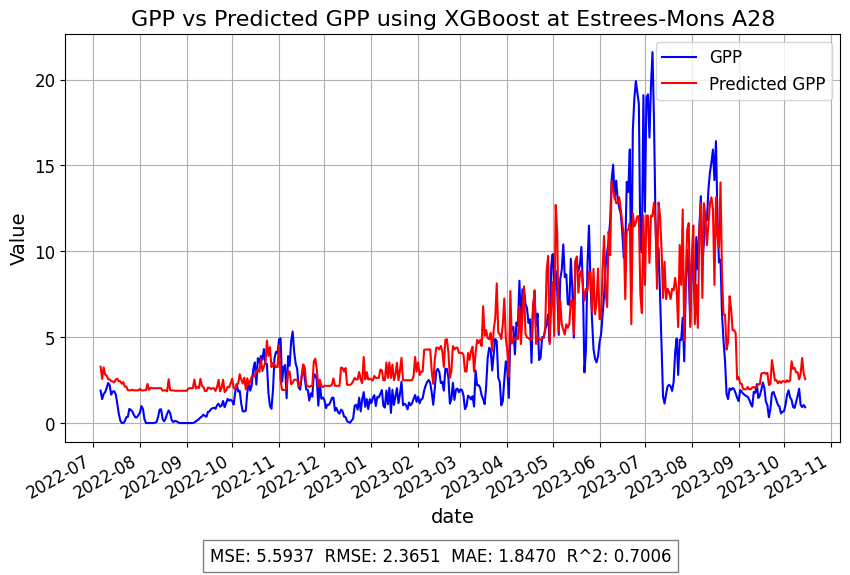

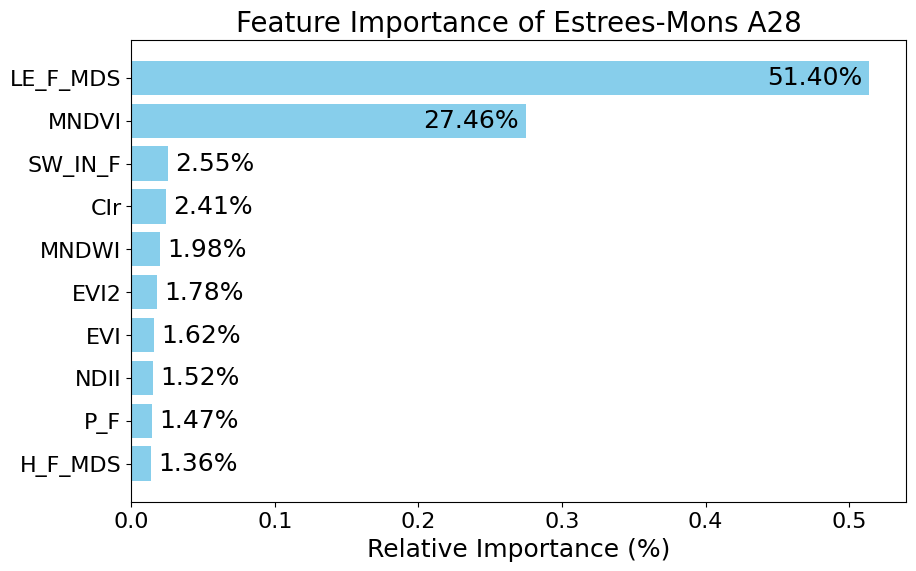

Retraining the model on the second site
Mean Squared Error: 4.26196732881242
Root Mean Squared Error: 2.0644532760061245
MAE: 1.6356033962331422
Test R^2 Score: 0.8560139498294816


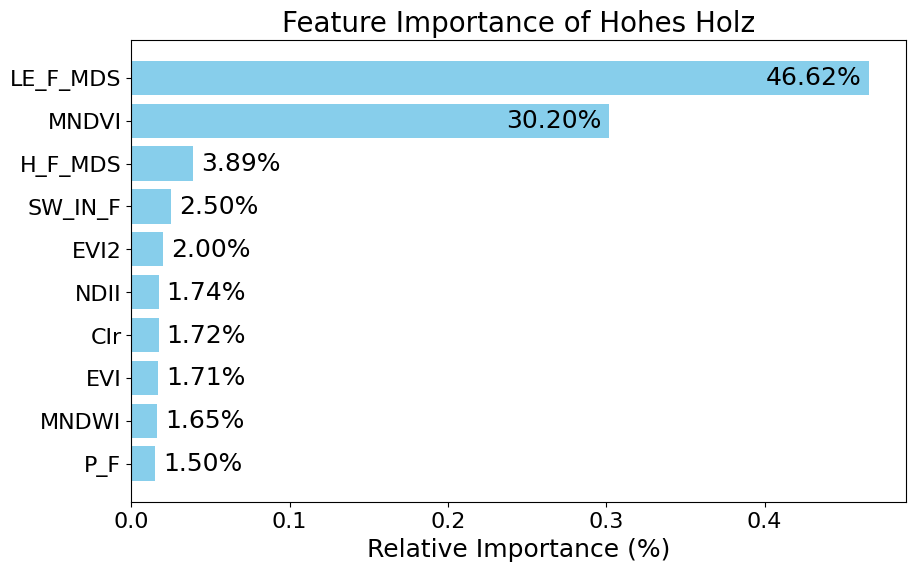

Retesting the model on the first site
Estrees-Mons A28
Mean Squared Error: 7.759894376953844
Root Mean Squared Error: 2.7856586971403807
MAE: 2.0033638215168548
Test R^2 Score: 0.5846786538147204


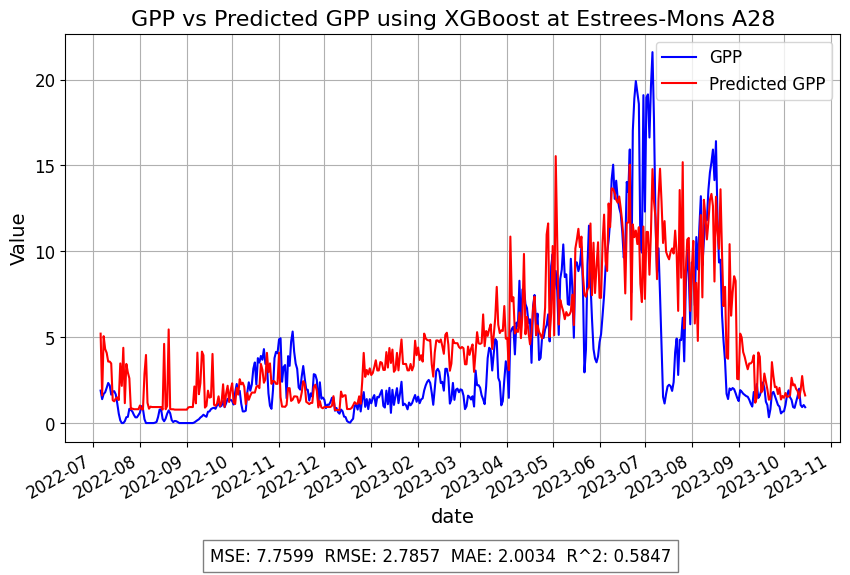

Hohes Holz
Mean Squared Error: 4.26196732881242
Root Mean Squared Error: 2.0644532760061245
MAE: 1.6356033962331422
Test R^2 Score: 0.8560139498294816


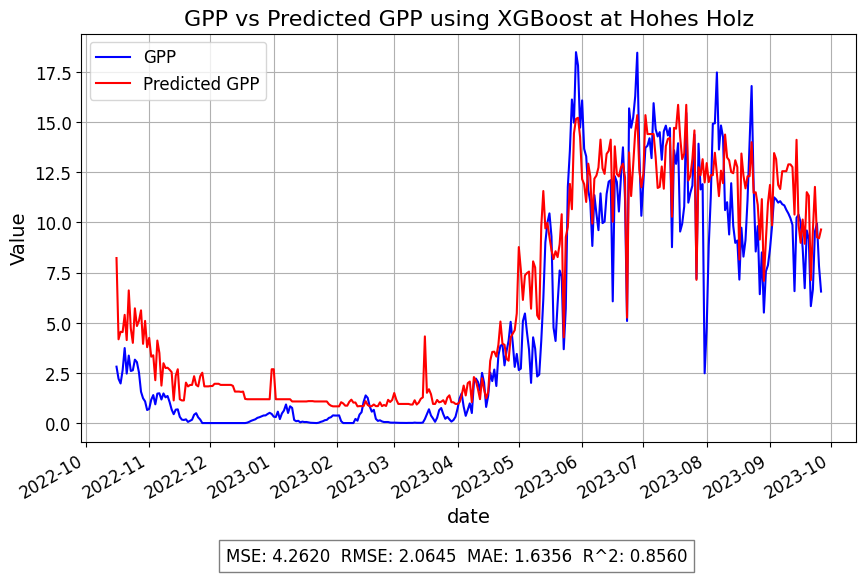

Retraining the model on the third site
Mean Squared Error: 2.603833713453916
Root Mean Squared Error: 1.6136398958422897
MAE: 1.1434043816245834
Test R^2 Score: 0.767696790835563


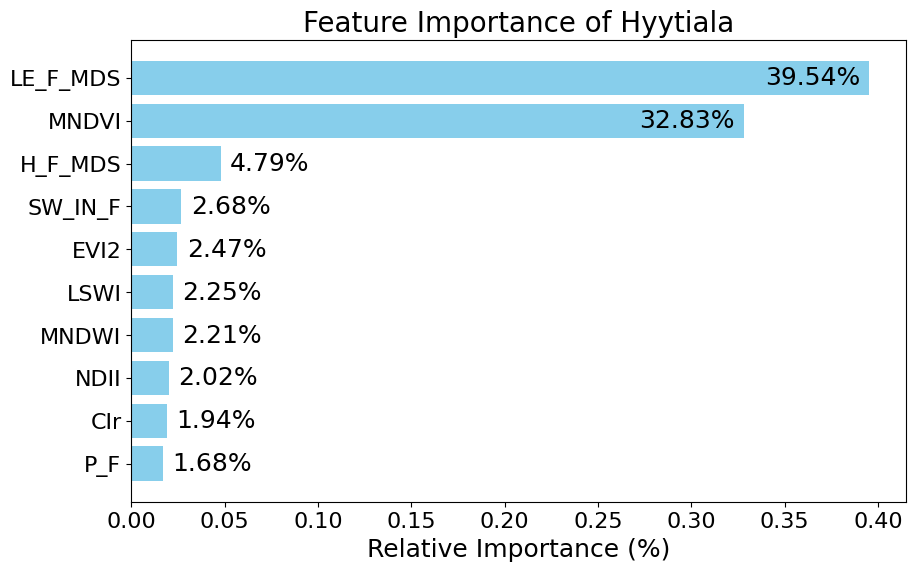

Estrees-Mons A28
Retesting the model on the first and second site
Mean Squared Error: 6.780670704966376
Root Mean Squared Error: 2.6039721014185955
mae: 1.893944420195985
Test R^2 Score: 0.6370881936757482


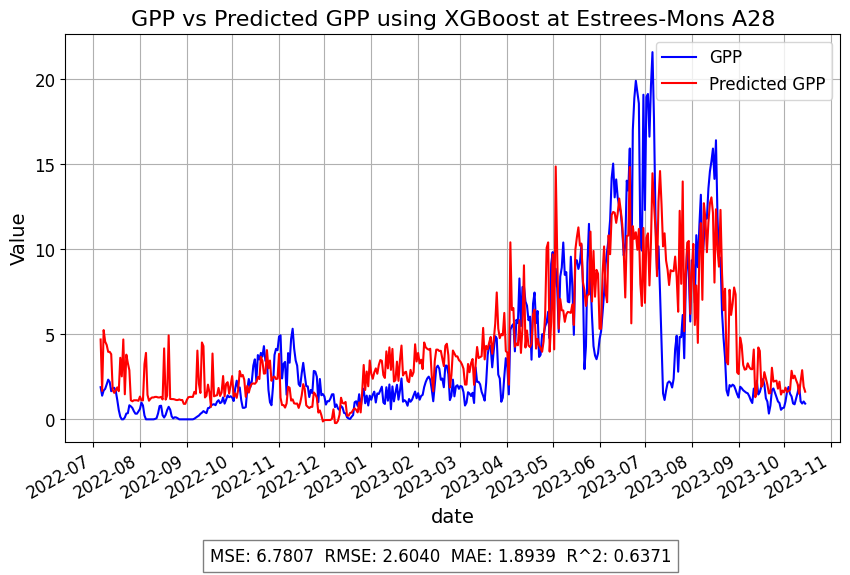

Hohes Holz
Mean Squared Error: 3.4393422163702834
Root Mean Squared Error: 1.8545463640390023
MAE: 1.4253820524061978
Test R^2 Score: 0.8838054675895735


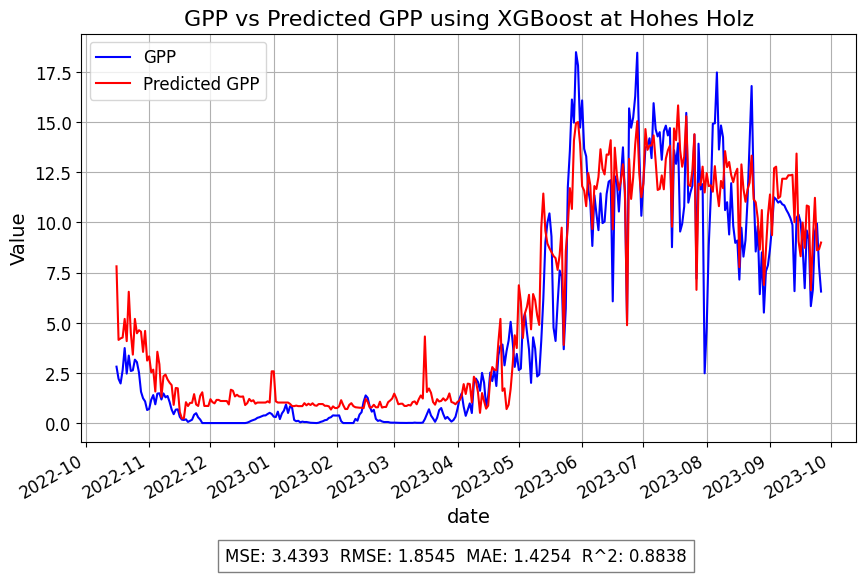

Hyytiala
Mean Squared Error: 2.603833713453916
Root Mean Squared Error: 1.6136398958422897
MAE: 1.1434043816245834
Test R^2 Score: 0.767696790835563


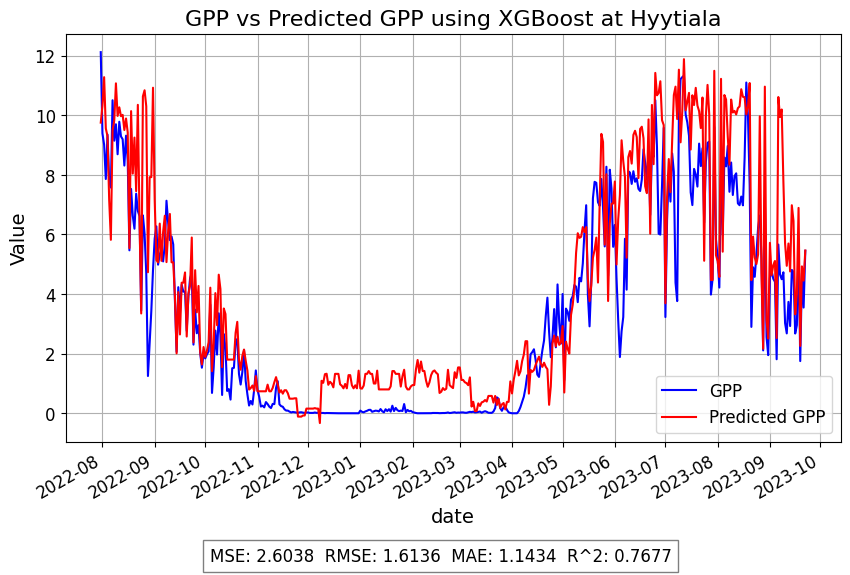

Retraining the model on the fourth site
Mean Squared Error: 3.2823188682309734
Root Mean Squared Error: 1.8117171049120702
MAE: 1.0751215690928981
Test R^2 Score: 0.6254697487764458


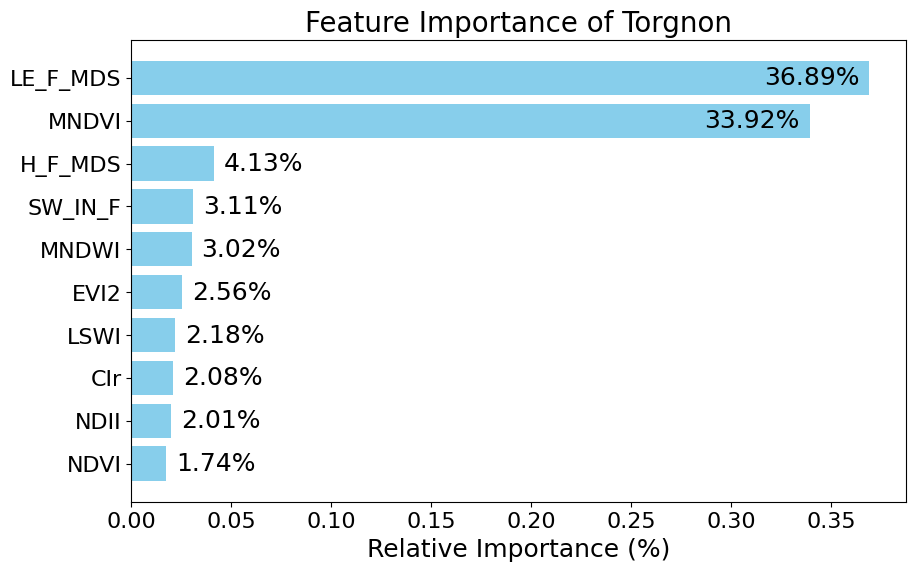

Estrees-Mons A28
Retesting the model on the first, second, and third site
Mean Squared Error: 6.889303701363269
Root Mean Squared Error: 2.6247483120031276
MAE: 1.799511331500999
Test R^2 Score: 0.6312739905291573


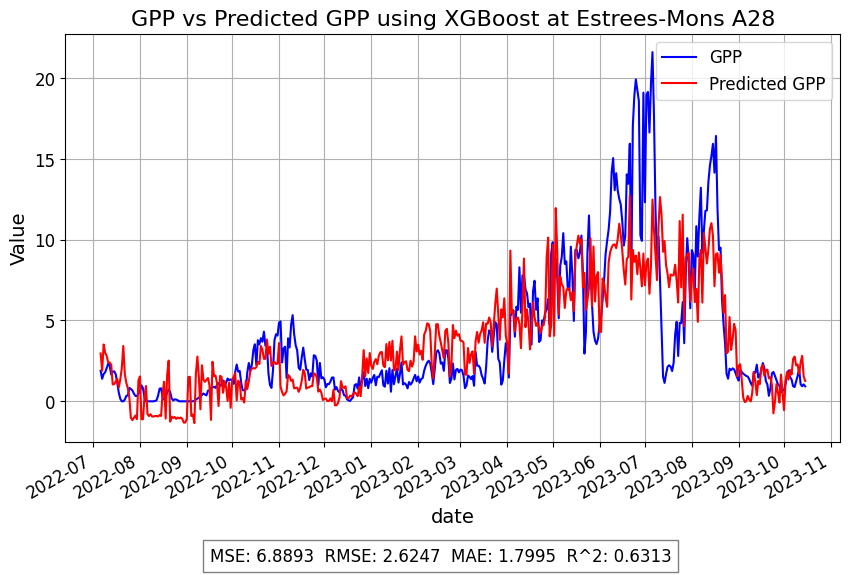

Hohes Holz
Mean Squared Error: 4.048595282332064
Root Mean Squared Error: 2.012112144571486
MAE: 1.4581130446883486
Test R^2 Score: 0.8632224983281551


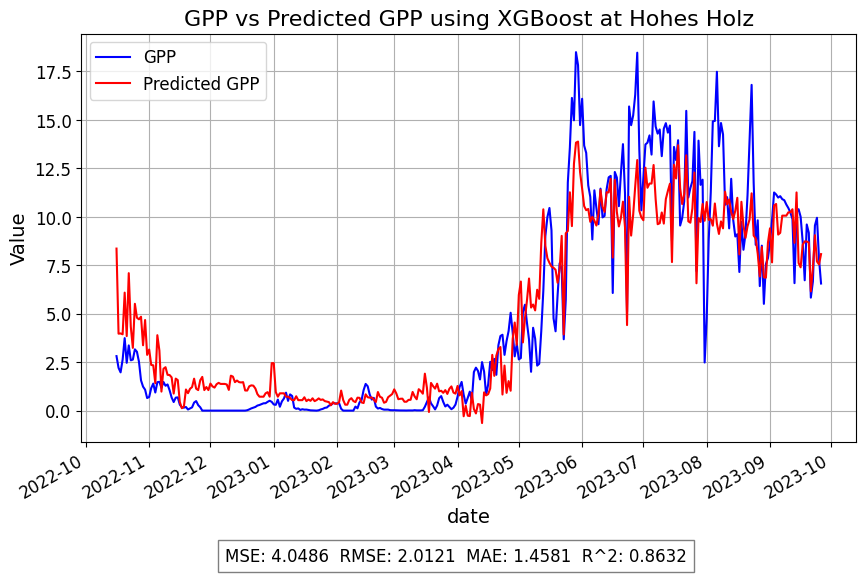

Hyytiala
Mean Squared Error: 2.167015303819104
Root Mean Squared Error: 1.472078565776672
MAE: 1.0259803147960114
Test R^2 Score: 0.8066679117085889


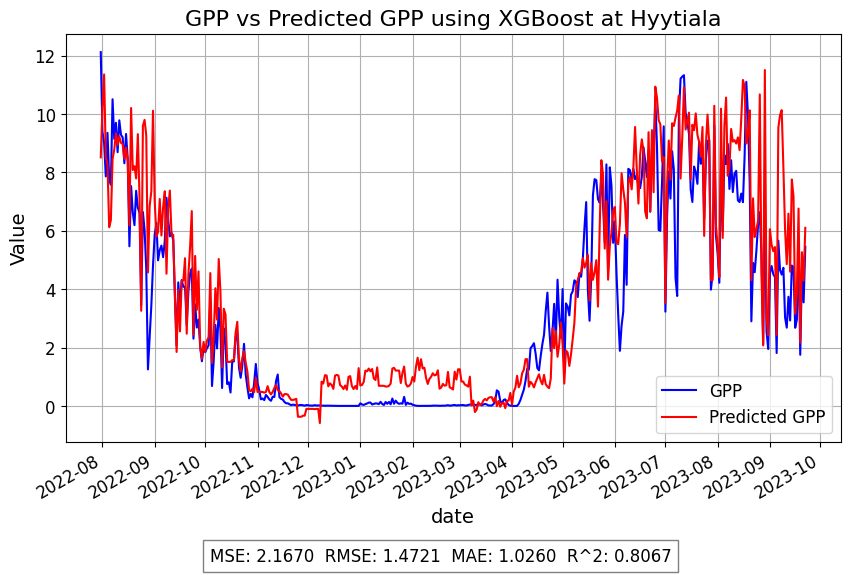

Torgnon
Mean Squared Error: 3.2823188682309734
Root Mean Squared Error: 1.8117171049120702
MAE: 1.0751215690928981
Test R^2 Score: 0.6254697487764458


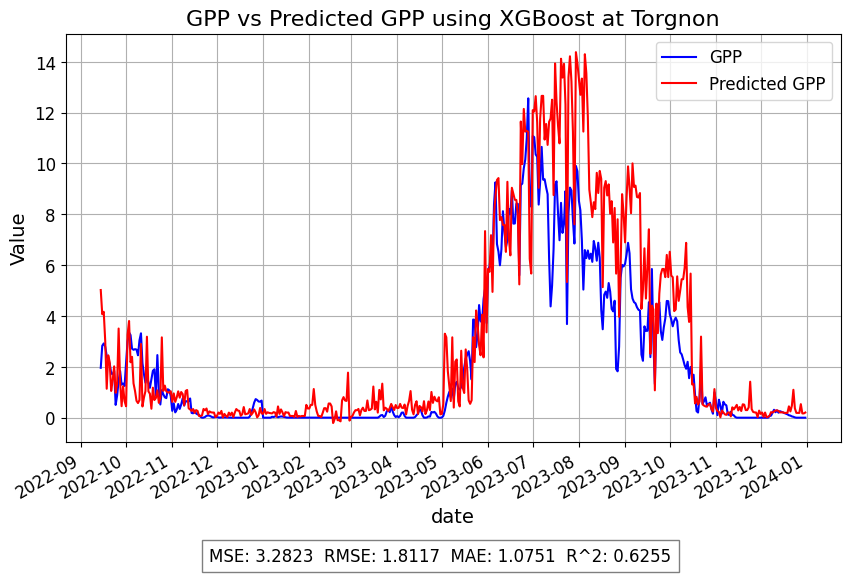

average MSE 4.096808288936352
average RMSE 1.9801640318158387
average MAE 1.3396815650195644
average R2 0.7316585373355868
Mean Squared Error: 4.97543313645651
Root Mean Squared Error: 2.2305678955047545
MAE: 1.5853921234648516
Test R^2 Score: 0.7642415060608693


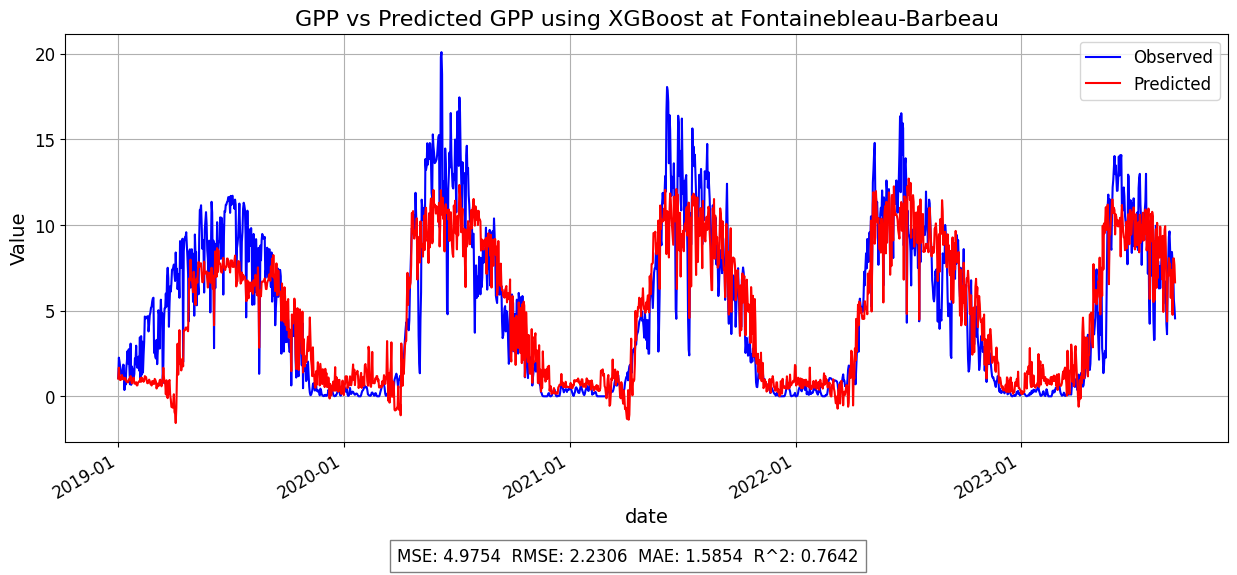

Mean Squared Error: 4.919521783080511
Root Mean Squared Error: 2.2179995002435215
MAE: 1.5986511036798456
Test R^2 Score: 0.6718405976696655


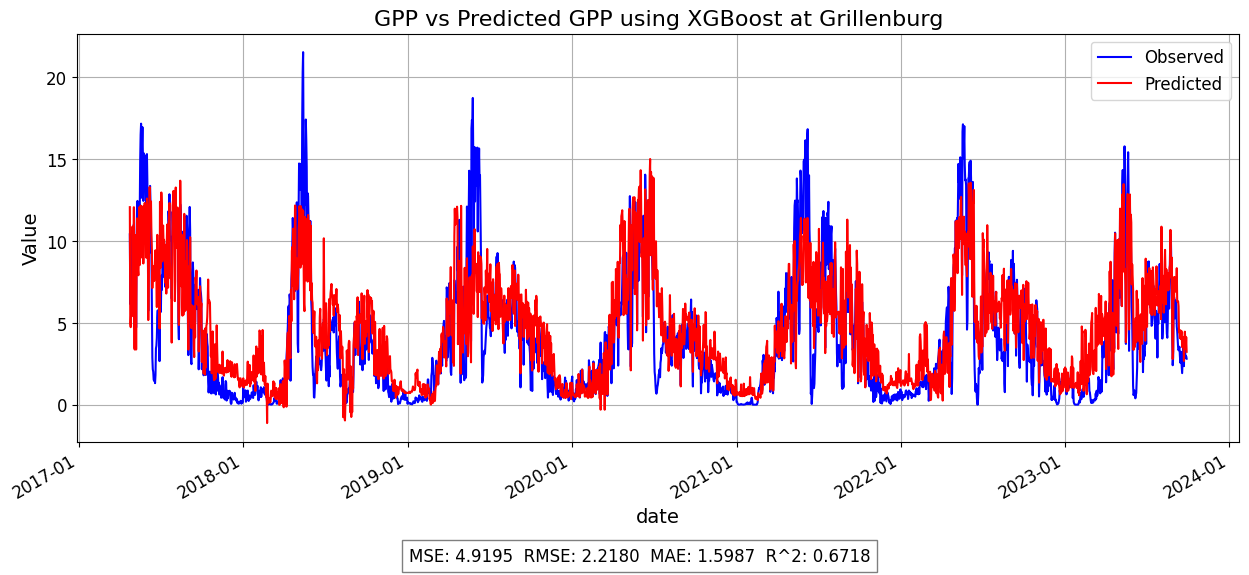

Mean Squared Error: 5.474727157442904
Root Mean Squared Error: 2.3398134877470262
MAE: 1.4247218371026233
Test R^2 Score: 0.6944853244393537


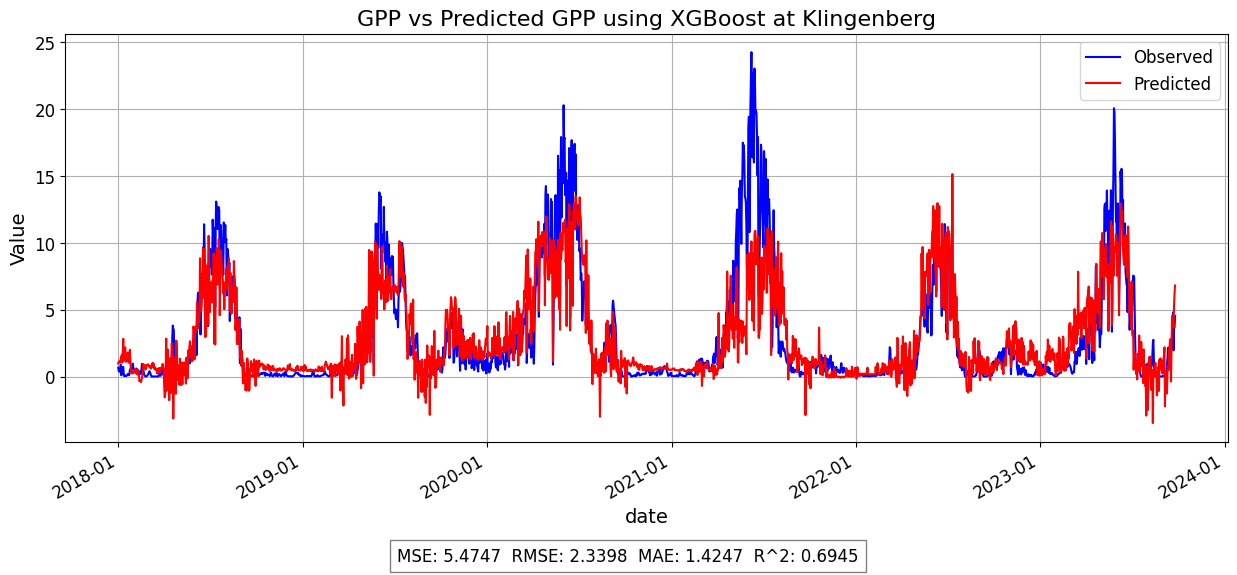

Mean Squared Error: 3.266838787473843
Root Mean Squared Error: 1.8074398433900485
MAE: 1.296726562656007
Test R^2 Score: 0.7243652840841956


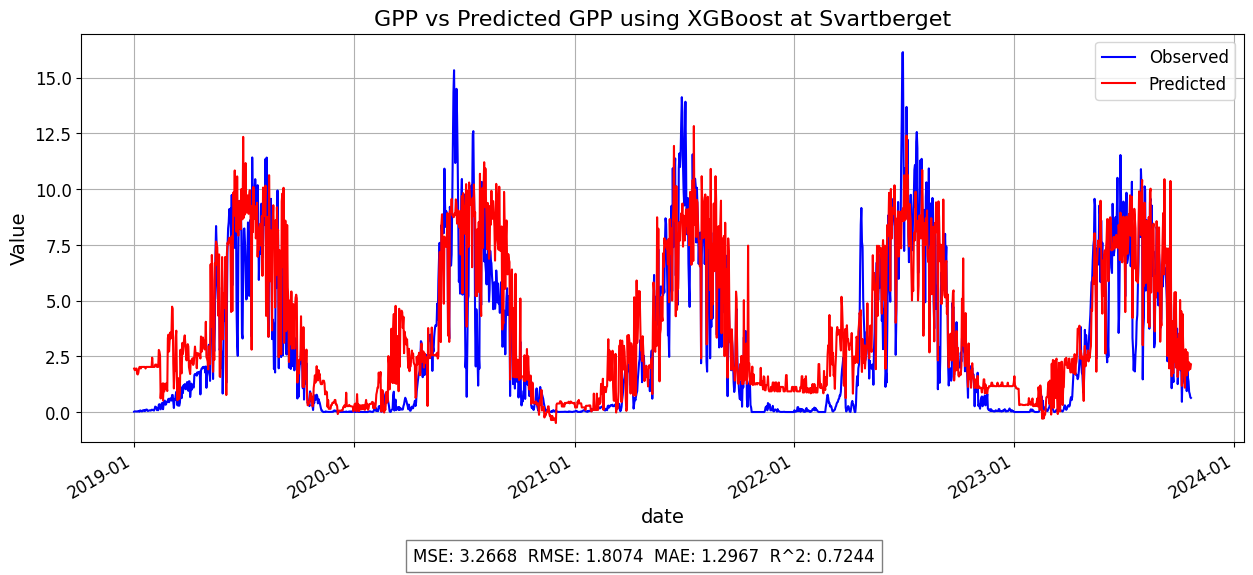

average MSE 4.659130216113442
average RMSE 2.1489551817213375
average MAE 1.4763729067258318
average R2 0.713733178063521


In [5]:
# Number of lag features
column = col2
col_name = 'col2'
max_depth = 6
min_child_weight = 5
L = 0  # Only use the current day
eta = 0.1
gamma = 0
alpha = 1
files =[
 'Estrees-Mons A28_preprocessed_26052017_15102023.csv',
 'Hohes Holz_preprocessed_01012019_26092023.csv',
 'Hyytiala_preprocessed_01012018_22092023.csv',
 'Torgnon_preprocessed_06072017_31122023.csv',
 ]

params = f"eta_{eta}_max_depth_{max_depth}_min_child_weight_{min_child_weight}_gamma_{gamma}_alpha_{alpha}_L_{L}_{col_name}"
model, features = retrain_XGBOOST(files,column, L, target_col, eta, max_depth, min_child_weight, gamma, alpha,plot_directory, params)
y_test1, y_pred1, y_test2, y_pred2, y_test3, y_pred3, y_test4, y_pred4 = predict_all(model,params,L,column)

best

First training and testing the model on the first site


C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Mean Squared Error: 5.726061877018396
Root Mean Squared Error: 2.392919112092675
MAE: 1.905815335482729
Test R^2 Score: 0.6940644174620554


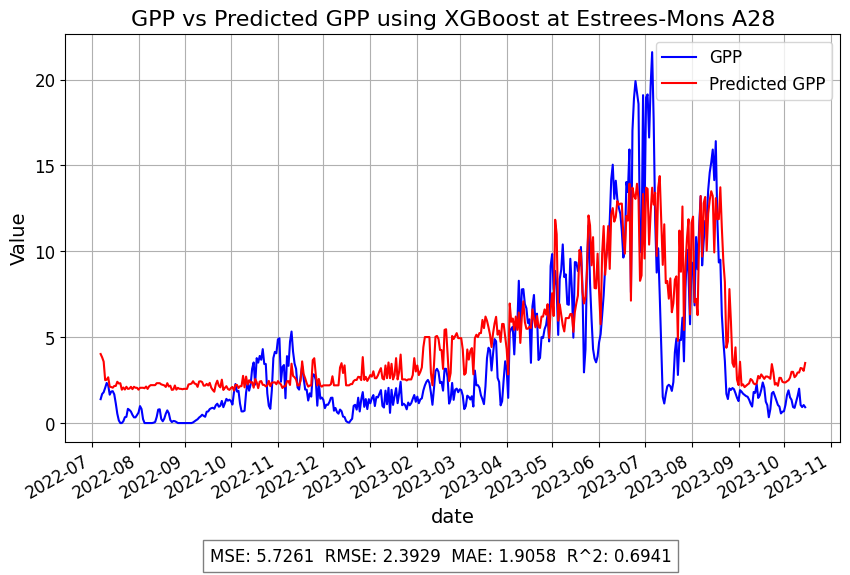

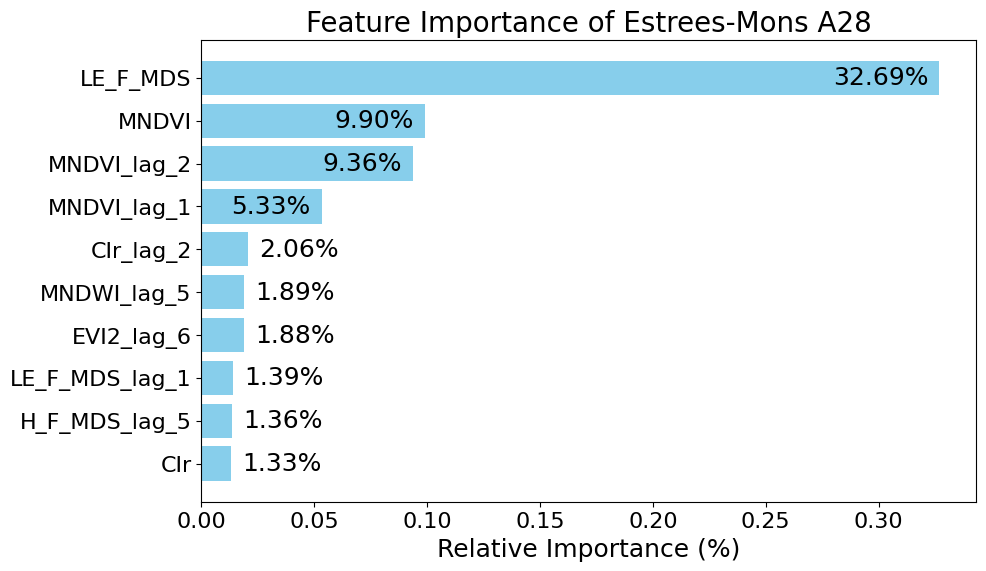

Retraining the model on the second site


C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Mean Squared Error: 4.294124007977328
Root Mean Squared Error: 2.072226823486591
MAE: 1.5676848945012378
Test R^2 Score: 0.8552834746798358


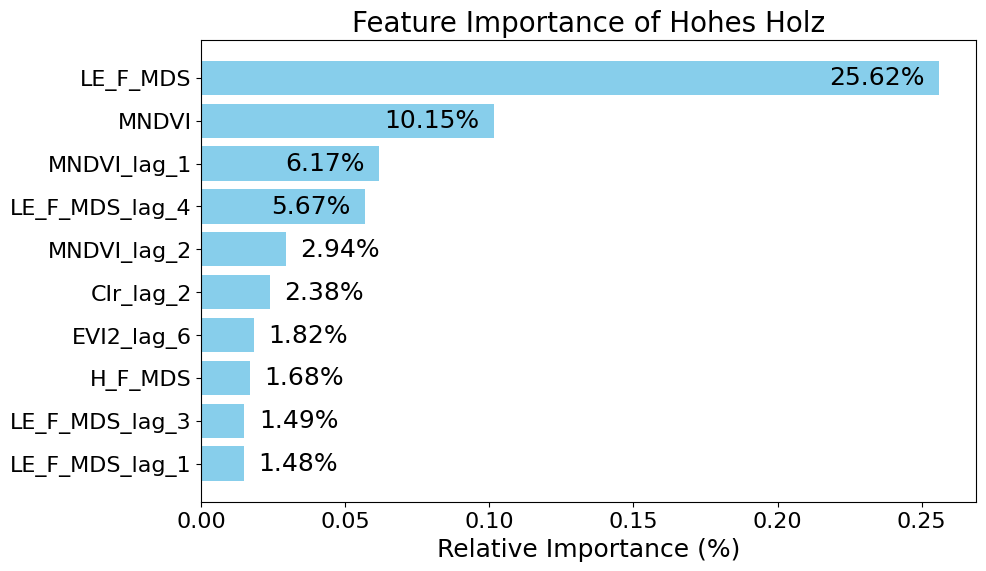

Retesting the model on the first site
Estrees-Mons A28
Mean Squared Error: 9.8288378649662
Root Mean Squared Error: 3.1350977440848955
MAE: 2.3072663963893887
Test R^2 Score: 0.47485875939307776


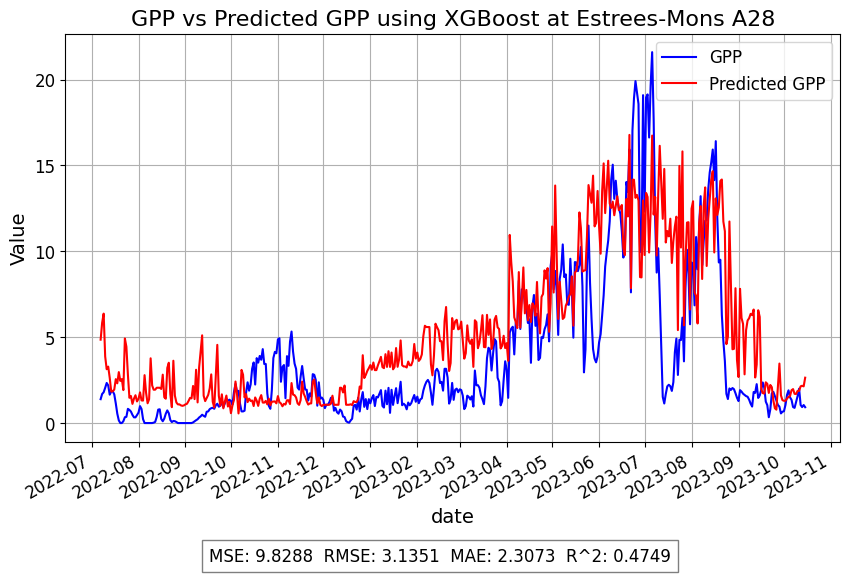

Hohes Holz
Mean Squared Error: 4.294124007977328
Root Mean Squared Error: 2.072226823486591
MAE: 1.5676848945012378
Test R^2 Score: 0.8552834746798358


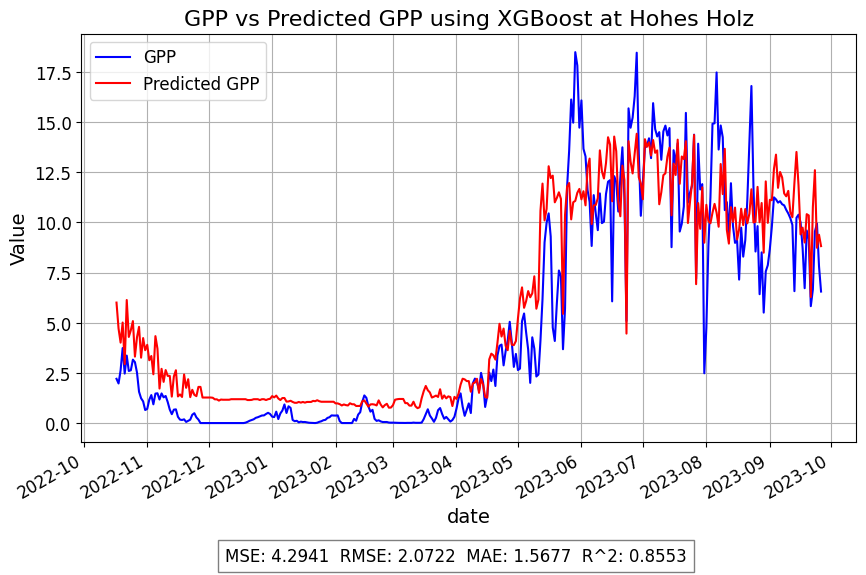

Retraining the model on the third site


C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Mean Squared Error: 2.7583039708797514
Root Mean Squared Error: 1.660814249360762
MAE: 1.1959403384311358
Test R^2 Score: 0.748932732830032


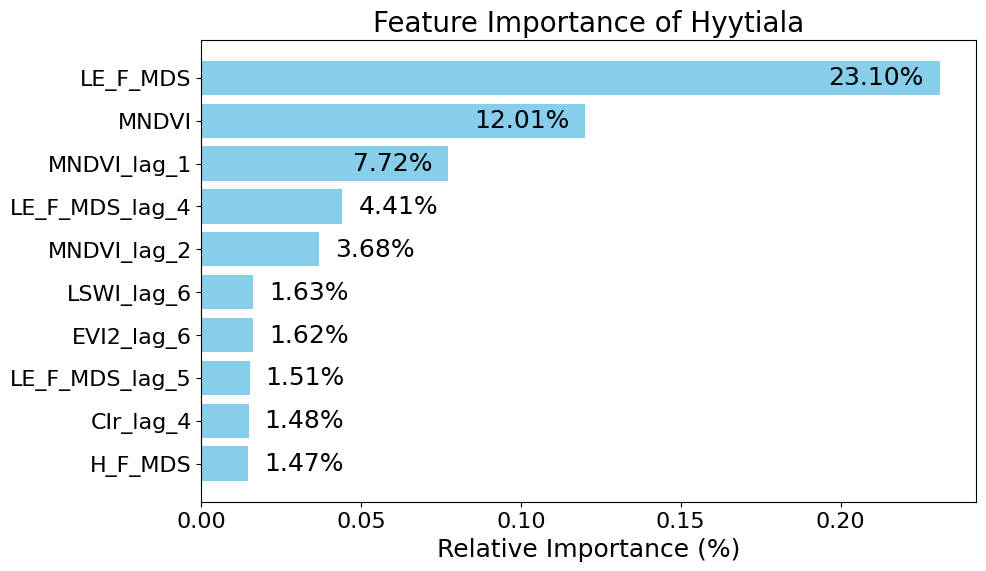

Estrees-Mons A28
Retesting the model on the first and second site
Mean Squared Error: 7.279082447184775
Root Mean Squared Error: 2.69797747343909
mae: 1.9481530712574464
Test R^2 Score: 0.6110886719965413


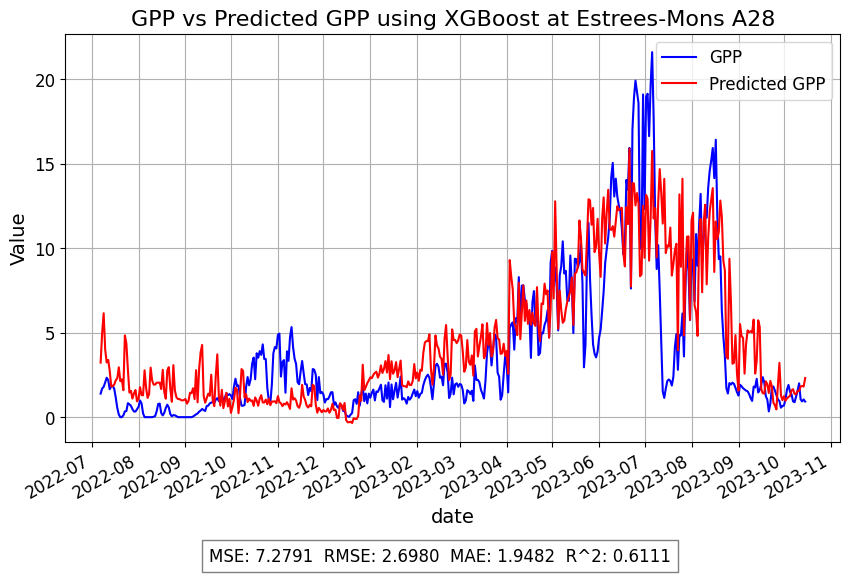

Hohes Holz
Mean Squared Error: 3.7738640276637985
Root Mean Squared Error: 1.9426435668088469
MAE: 1.2920153877032388
Test R^2 Score: 0.8728167868231838


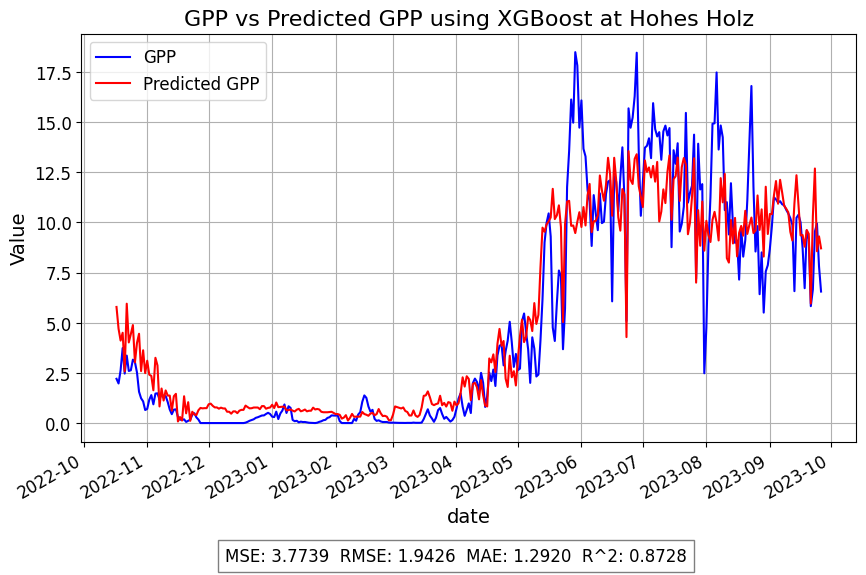

Hyytiala
Mean Squared Error: 2.7583039708797514
Root Mean Squared Error: 1.660814249360762
MAE: 1.1959403384311358
Test R^2 Score: 0.748932732830032


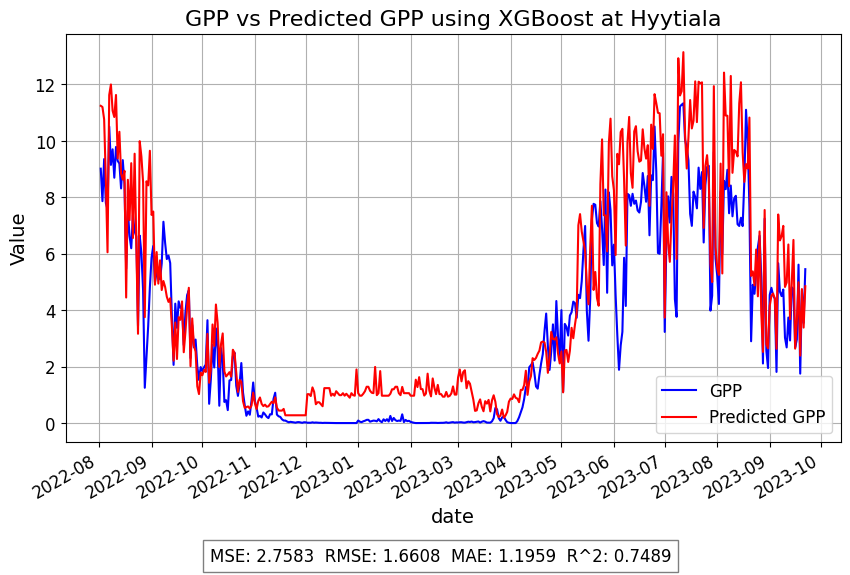

Retraining the model on the fourth site


C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Mean Squared Error: 3.0542194955102353
Root Mean Squared Error: 1.7476325401840729
MAE: 1.0639103998867008
Test R^2 Score: 0.652228763869779


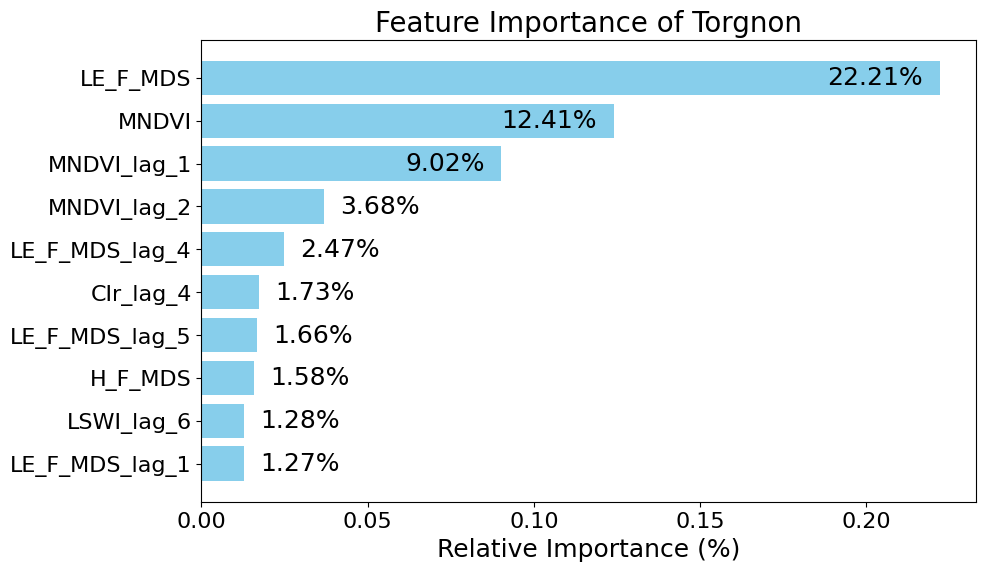

Estrees-Mons A28
Retesting the model on the first, second, and third site
Mean Squared Error: 6.347303648751111
Root Mean Squared Error: 2.519385569687798
MAE: 1.733795160173197
Test R^2 Score: 0.6608723270840662


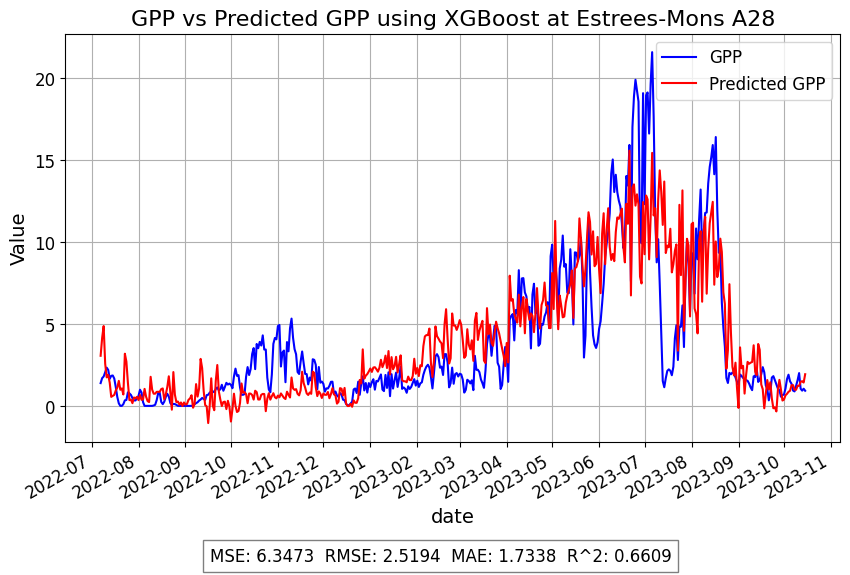

Hohes Holz
Mean Squared Error: 4.073343423947601
Root Mean Squared Error: 2.0182525669369533
MAE: 1.327240647158779
Test R^2 Score: 0.862724014105242


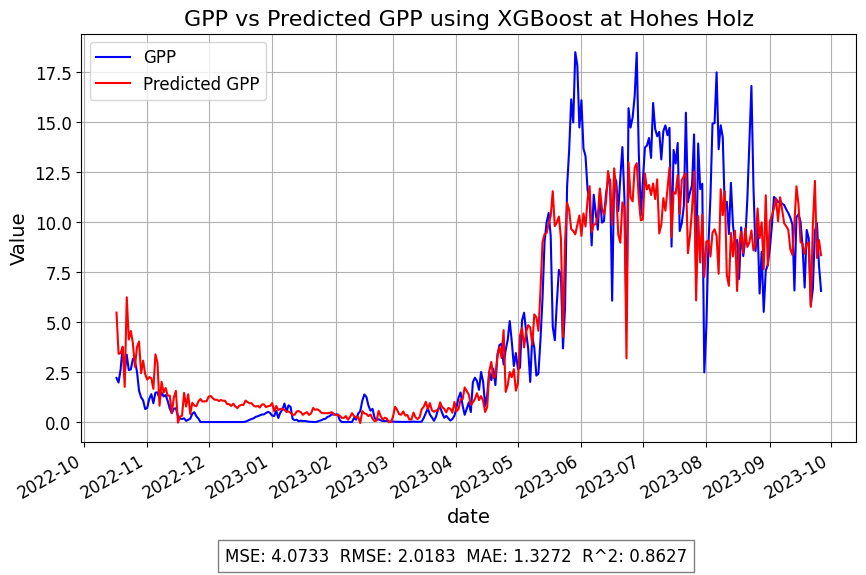

Hyytiala
Mean Squared Error: 2.313545877493331
Root Mean Squared Error: 1.5210344761028038
MAE: 1.028175888534541
Test R^2 Score: 0.7894156528552093


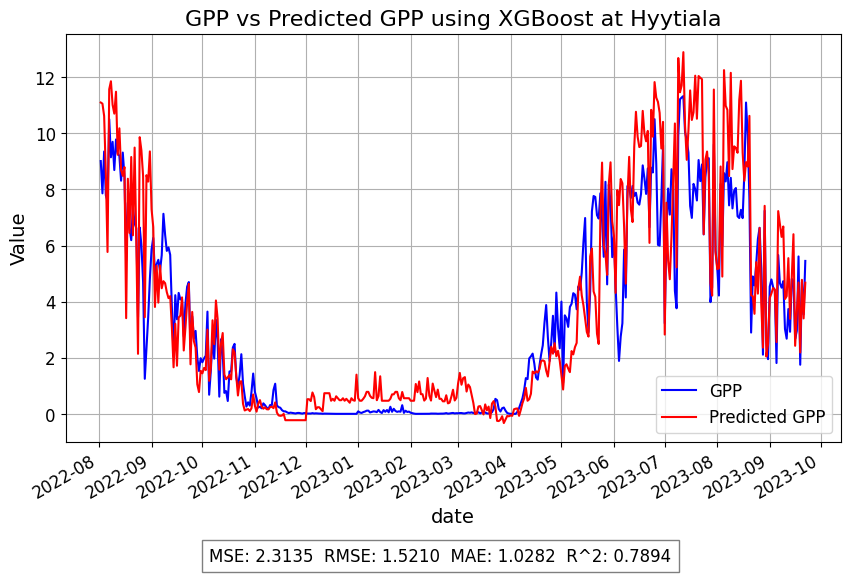

Torgnon
Mean Squared Error: 3.0542194955102353
Root Mean Squared Error: 1.7476325401840729
MAE: 1.0639103998867008
Test R^2 Score: 0.652228763869779


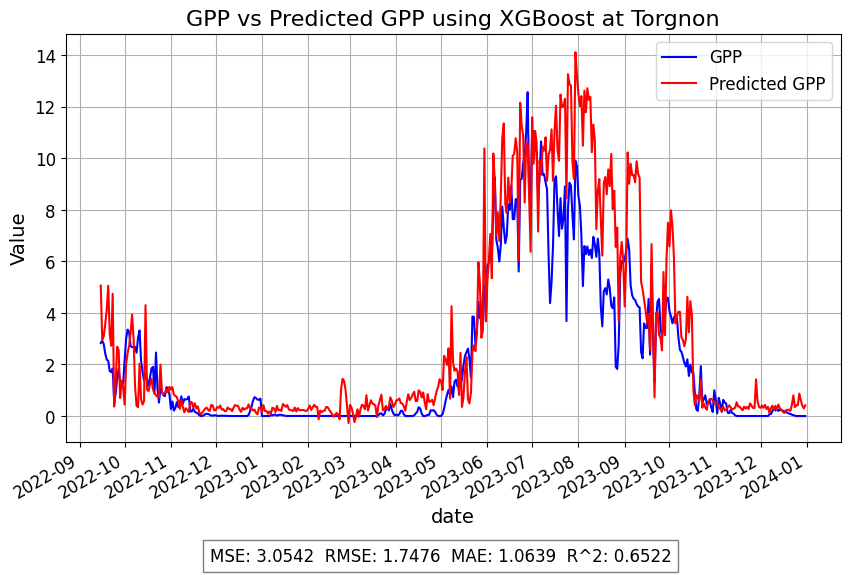

average MSE 3.94710311142557
average RMSE 1.951576288227907
average MAE 1.2882805239383044
average R2 0.7413101894785742
Mean Squared Error: 4.626599232165204
Root Mean Squared Error: 2.1509530985507808
MAE: 1.5112834491916767
Test R^2 Score: 0.7811342543067759


C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

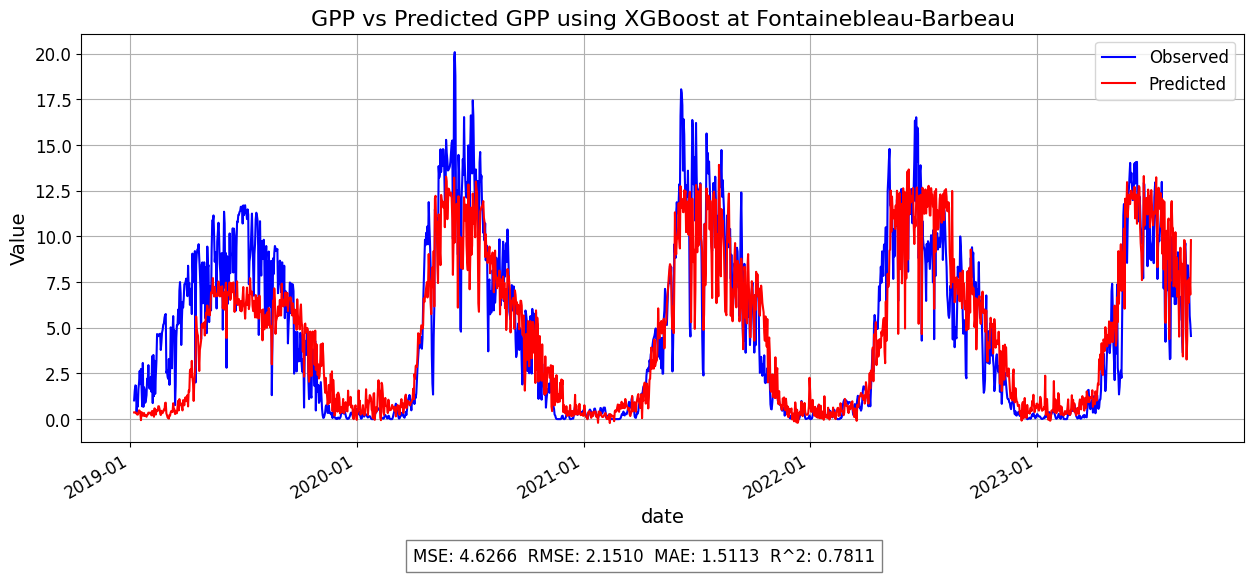

C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Mean Squared Error: 5.149954735133725
Root Mean Squared Error: 2.2693511705185085
MAE: 1.6033316379996903
Test R^2 Score: 0.6564965364346473


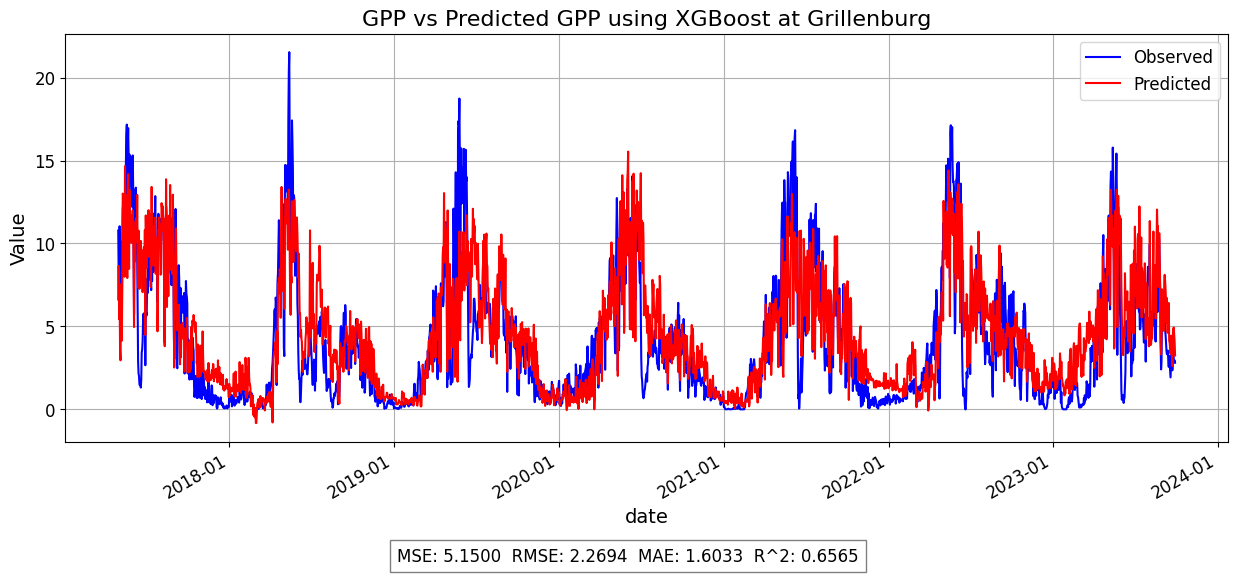

C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Mean Squared Error: 5.6739258377107396
Root Mean Squared Error: 2.3820003857494942
MAE: 1.4258166716321257
Test R^2 Score: 0.6839876940217043


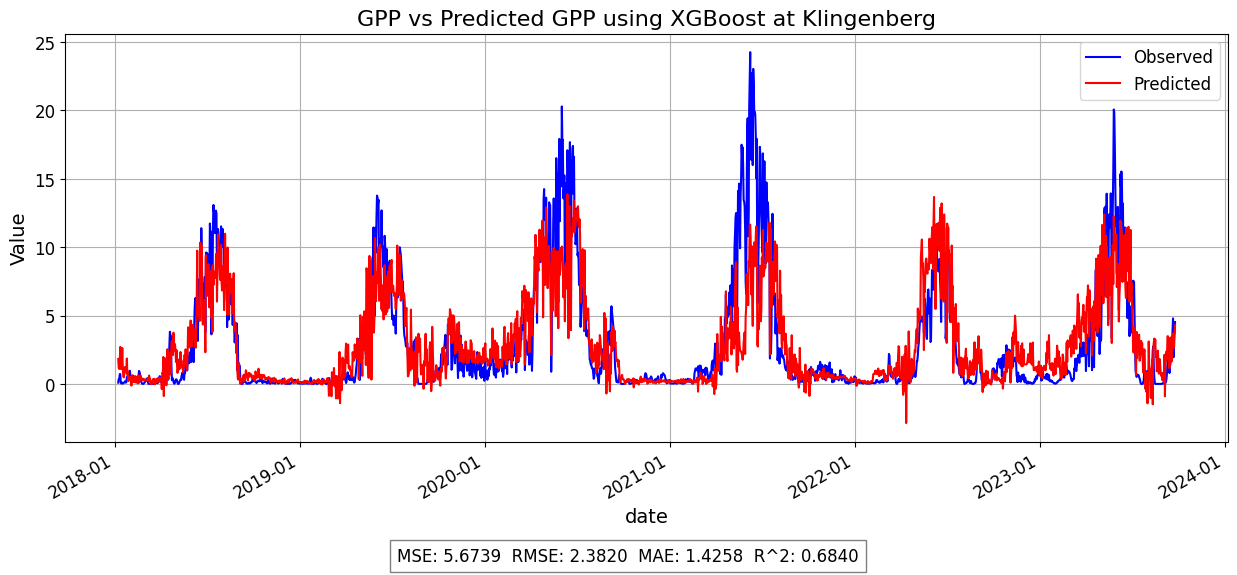

C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_lag_{i}'] = df[column].shift(i)
C:\Users\karisma\AppData\Local\Temp\ipykernel_16188\1708116150.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Mean Squared Error: 2.740388868400355
Root Mean Squared Error: 1.6554119935533738
MAE: 1.1514056619225814
Test R^2 Score: 0.7689903732068009


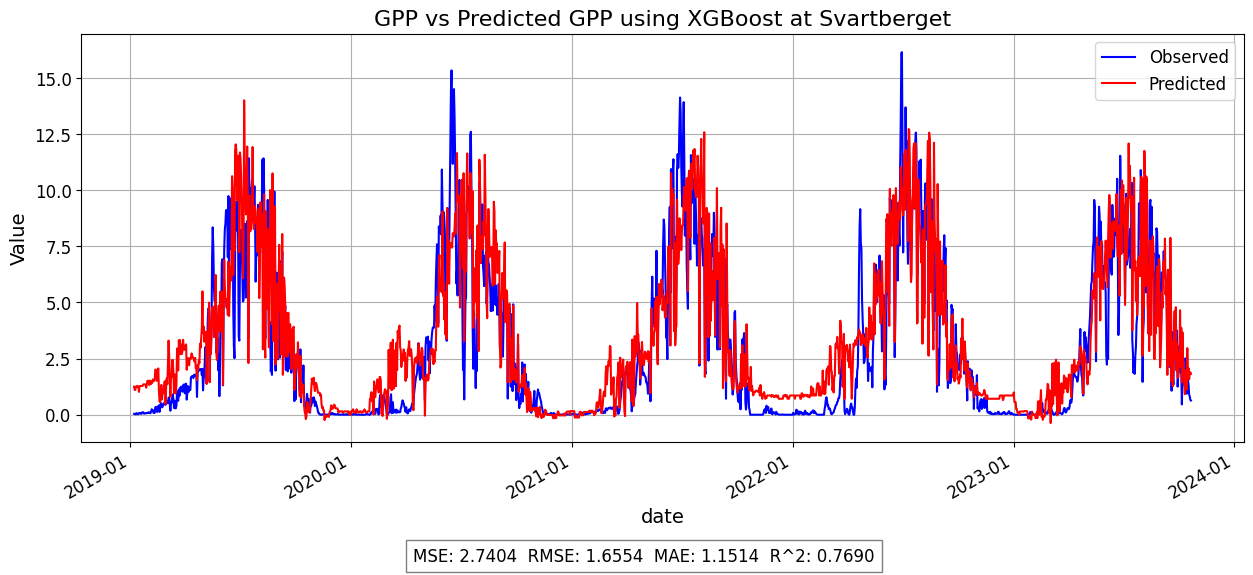

average MSE 4.547717168352506
average RMSE 2.1144291620930393
average MAE 1.4229593551865185
average R2 0.7226522144924821


In [7]:
# Number of lag features
column = col2
col_name = 'col2'
max_depth = 6
min_child_weight = 5
L = 7  # For example, create lag features for the previous 3 time points
eta = 0.1
gamma = 0
alpha = 1
files =[
 'Estrees-Mons A28_preprocessed_26052017_15102023.csv',
 'Hohes Holz_preprocessed_01012019_26092023.csv',
 'Hyytiala_preprocessed_01012018_22092023.csv',
 'Torgnon_preprocessed_06072017_31122023.csv',
 ]

params = f"eta_{eta}_max_depth_{max_depth}_min_child_weight_{min_child_weight}_gamma_{gamma}_alpha_{alpha}_L_{L}_{col_name}"
model_, features = retrain_XGBOOST(files,column, L, target_col, eta, max_depth, min_child_weight, gamma, alpha,plot_directory, params)
y_test1_, y_pred1_, y_test2_, y_pred2_, y_test3_, y_pred3_, y_test4_, y_pred4_ = predict_all(model_,params,L,column)